In [1]:
from __future__ import print_function, division

import pyexotica as exo
from pyexotica.publish_trajectory import *
import exotica_ddp_solver_py
import signal, sys
from time import time, sleep
import numpy as np

exo.Setup.init_ros("exotica_cartpole_dataset_computation")
sleep(0.5)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
solver = exo.Setup.load_solver('cartpole_cjp_boxfddp.xml')
problem = solver.get_problem()
ds = problem.get_scene().get_dynamics_solver()

## Test solve the optimal control problem

In [3]:
problem.U = -1. * np.random.random(problem.U.shape)
for t in range(problem.T - 1):
    problem.update(problem.U[:,t],t)
#problem.start_state = np.random.random(problem.start_state.shape)

solver.debug_mode = False
solver.max_iterations = 1000
solution = solver.solve()
print("Solved in", solver.get_planning_time(), problem.termination_criterion)

Solved in 0.041555092 TerminationCriterion.Convergence


### Plot the cost convergence vs time and vs iterations

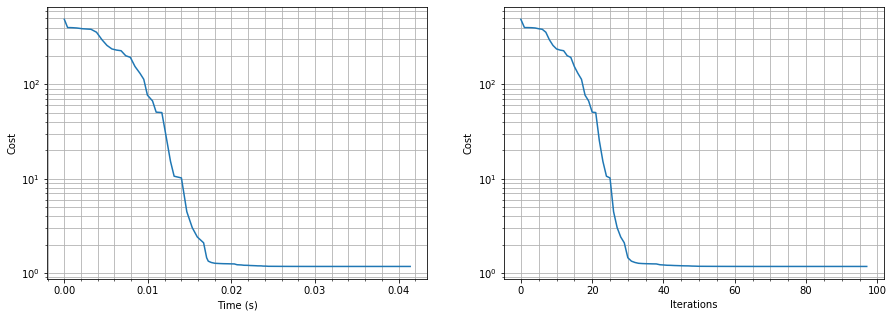

X [ 0.0015  3.1315 -0.0019  0.003 ]
X* [0. 0. 0. 0.]
True 0.011697457975934274


In [4]:
costs = problem.get_cost_evolution()

fig = plt.figure(1)
fig.set_size_inches(15,5)
fig.add_subplot(1,2,1)
plt.plot(costs[0], costs[1])
plt.xlabel('Time (s)')
plt.ylabel('Cost')
plt.yscale('log')
plt.minorticks_on()
plt.grid(which='both')

fig.add_subplot(1,2,2)
plt.plot(costs[1])
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.minorticks_on()
plt.grid(which='both')

plt.show()

print("X",problem.X[:,-1])
print("X*",problem.X_star[:,-1])
print(problem.get_state_cost(-1) < 1, problem.get_state_cost(-1))

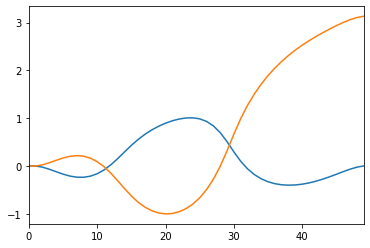

In [5]:
plt.plot(problem.X[0:2].T)
plt.xlim(0, problem.T-1)
plt.show()

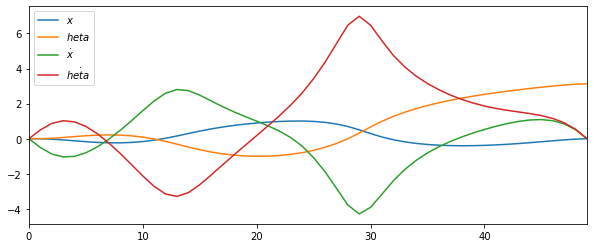

In [6]:
fig = plt.figure(2)
fig.set_size_inches([10,4])
plt.plot(problem.X.T)
plt.legend(['$x$', '$\theta$', '$\dot{x}$', '$\dot{\theta}$'])
plt.xlim(0, problem.T-1)
plt.show()

# Randomly sample policies to explore solution classes

## From (0,0) to (0,\pi)

In [7]:
desired_samples = 50
uniform_force_random = 5.
samples = []
state_trajectories = []
ss = time()
valid_sample_count = 0
while valid_sample_count < desired_samples:
    solver = exo.Setup.load_solver('cartpole_cjp_boxfddp.xml')
    problem = solver.get_problem()
    problem.U = np.random.uniform(size=problem.U.shape, low=-uniform_force_random, high=uniform_force_random)
    for t in range(problem.T - 1):
        problem.update(problem.U[:, t], t)

    solver.debug_mode = False
    solution = solver.solve()
    if problem.get_state_cost(-1) < 1. and np.max(np.abs(solution)) < 10. + 1e-2:
        samples.append(solution)
        print("Added solution", len(samples))
        state_trajectories.append(problem.X.copy())
        valid_sample_count += 1
    else:
        print("Bad sample:", problem.get_state_cost(-1))
ee = time()
print("Took", ee-ss)
print(len(samples), "valid samples")

Added solution 1
Added solution 2
Added solution 3
Added solution 4
Added solution 5
Added solution 6
Added solution 7
Added solution 8
Added solution 9
Added solution 10
Added solution 11
Added solution 12
Added solution 13
Added solution 14
Added solution 15
Added solution 16
Added solution 17
Added solution 18
Added solution 19
Added solution 20
Added solution 21
Added solution 22
Added solution 23
Added solution 24
Added solution 25
Added solution 26
Added solution 27
Added solution 28
Added solution 29
Added solution 30
Added solution 31
Added solution 32
Added solution 33
Added solution 34
Added solution 35
Added solution 36
Added solution 37
Added solution 38
Added solution 39
Added solution 40
Added solution 41
Added solution 42
Added solution 43
Added solution 44
Added solution 45
Added solution 46
Added solution 47
Added solution 48
Added solution 49
Added solution 50
Took 1.5514674186706543
50 valid samples


In [8]:
# Export to file, so we can play with ripser
print(len(samples), len(state_trajectories))
np.savez('cartpole_policies_analytic_from_zero_50', control_trajectories=np.array(samples), state_trajectories=np.array(state_trajectories))

50 50


## From (random, random) to (0, \pi)

In [9]:
from tqdm import tqdm

In [10]:
number_of_random_start_states = 50
desired_samples = 10  # per random start state

uniform_force_random = 0.5
samples = []
start_states = []
state_trajectories = []
ss = time()

#num_different_start_states = 0
#while num_different_start_states < 50:
for i in tqdm(range(number_of_random_start_states)):
    valid_sample_count = 0
    max_attempts = 0
    random_start_state = np.random.uniform(low=[-1.,-np.pi,-2.,-0.5 * np.pi], high=[1.,np.pi,2.,0.5 * np.pi])
    while (valid_sample_count < desired_samples) and not (max_attempts >  10 * desired_samples):
        solver = exo.Setup.load_solver('cartpole_cjp_boxfddp.xml')
        problem = solver.get_problem()
        max_attempts += 1
        problem.start_state = random_start_state
        The_Great_X = problem.X.copy()
        The_Great_X[:,0] = random_start_state
        problem.X = The_Great_X
        problem.U = np.random.uniform(size=problem.U.shape, low=-uniform_force_random, high=uniform_force_random)
        for t in range(problem.T - 1):
            problem.update(problem.U[:,t], t)
        solver.debug_mode = False
        solution = solver.solve()
        if problem.get_state_cost(-1) < 1e-1 and np.max(np.abs(solution)) < 10. + 1e-2:
            start_states.append(random_start_state)
            samples.append(solution)
            state_trajectories.append(problem.X.copy())
            valid_sample_count += 1
ee = time()
print("Took", ee-ss)
print(len(samples), "valid samples")

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]Took 34.77185678482056
427 valid samples



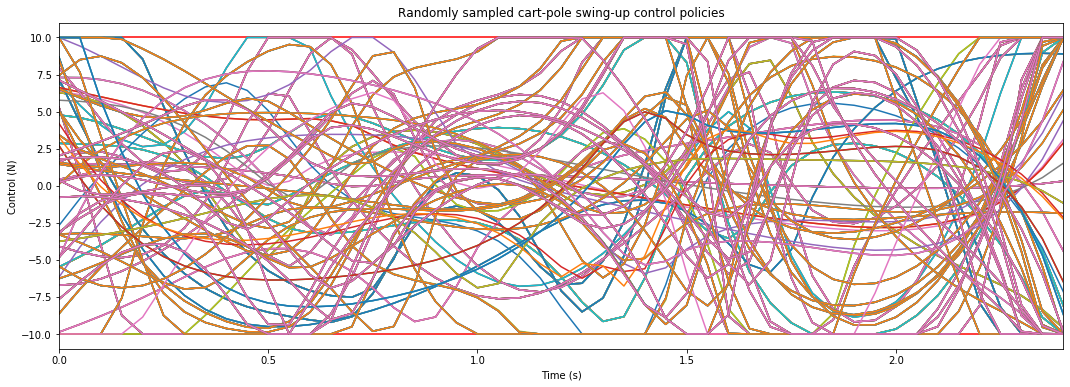

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
x_axis = np.arange(0, problem.T * problem.tau, problem.tau)
for sample in samples:
    ax.plot(x_axis[:-1], sample)
plt.xlabel('Time (s)')
plt.ylabel('Control (N)')
ax.hlines(y=10., xmin=0., xmax=problem.tau * problem.T, color='r')
ax.hlines(y=-10., xmin=0., xmax=problem.tau * problem.T, color='r')
plt.xlim(0, (problem.T - 2) * problem.tau)
plt.title('Randomly sampled cart-pole swing-up control policies')
plt.show()

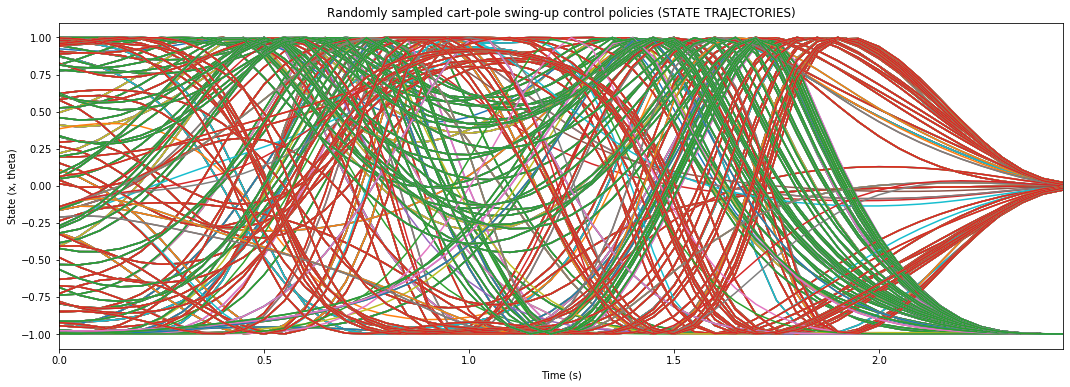

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(18,6)
x_axis = np.arange(0, problem. T * problem.tau, problem.tau)
for sample in state_trajectories:
    ax.plot(x_axis, np.cos(sample[1,:].T))
    ax.plot(x_axis, np.sin(sample[1,:].T))
    #ax.plot(x_axis, (sample[1,:].T))
plt.xlabel('Time (s)')
plt.ylabel('State (x, theta)')
plt.xlim(0, (problem.T-1) * problem.tau)
plt.title('Randomly sampled cart-pole swing-up control policies (STATE TRAJECTORIES)')
plt.show()

In [13]:
# Export to file, so we can play with ripser
np.savez('cartpole_policies_analytic_from_random_50', control_trajectories=np.array(samples), state_trajectories=np.array(state_trajectories))

# Explore Multimodality

In this test, we provide guess initialisations to force the emergence of both modes to plot them.

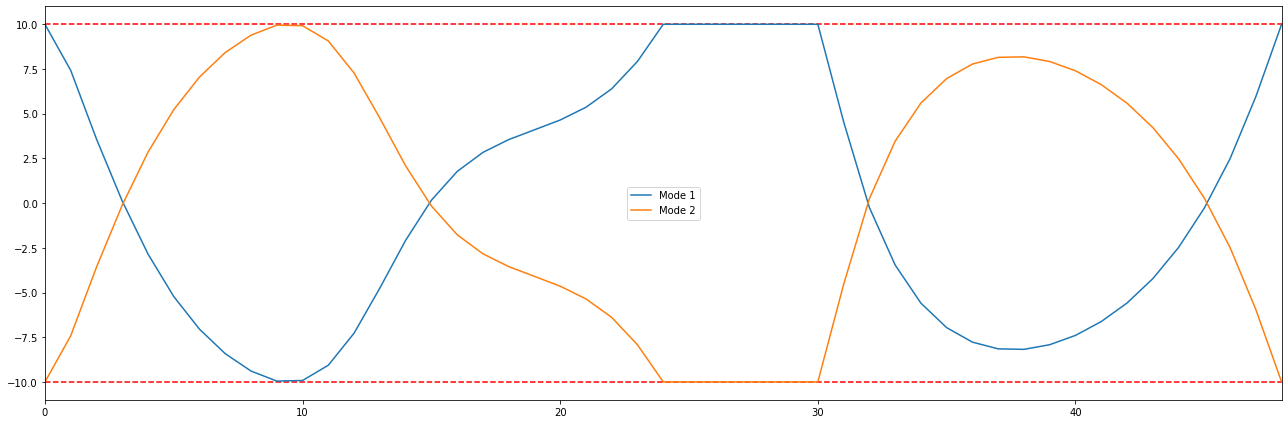

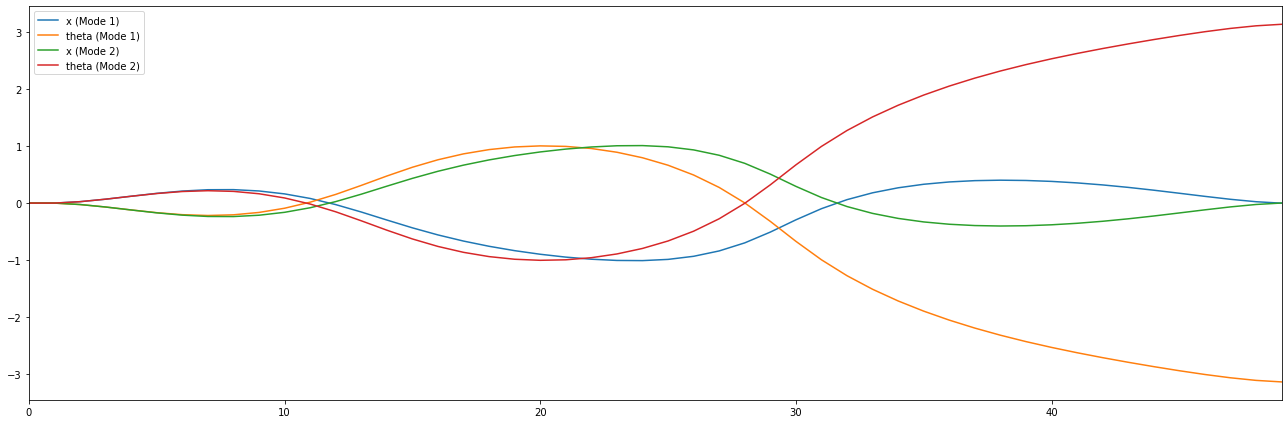

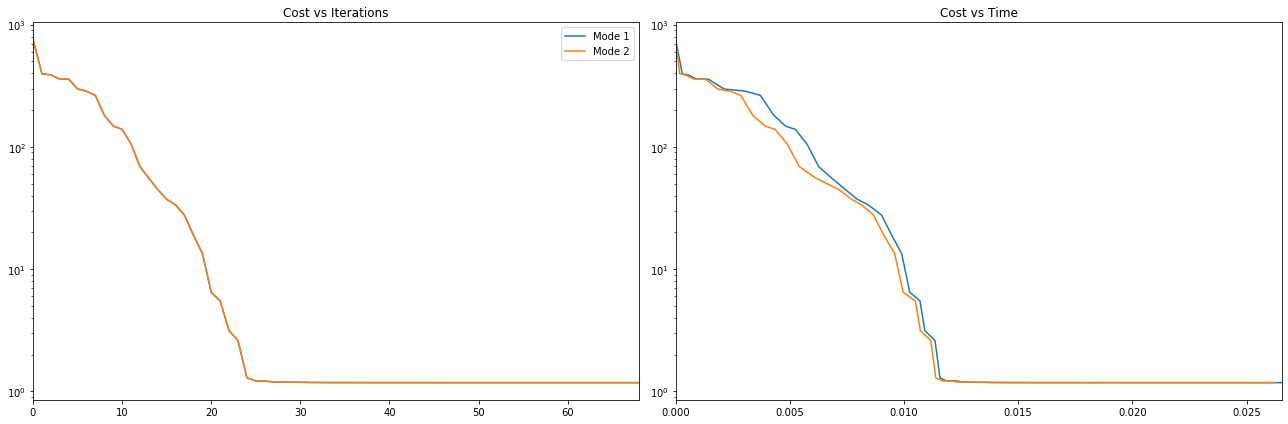

In [14]:
samples = []
state_trajectories = []

# Right
solver = exo.Setup.load_solver('cartpole_cjp_boxfddp.xml')
problem = solver.get_problem()

problem.U = 1. * np.ones(problem.U.shape)
for t in range(problem.T - 1):
    problem.update(problem.U[:,t], t)
solver.debug_mode = True
solution = solver.solve()
samples.append(solution)
state_trajectories.append(problem.X.copy())
right_cost_evolution = problem.get_cost_evolution()

# Left
solver = exo.Setup.load_solver('cartpole_cjp_boxfddp.xml')
problem = solver.get_problem()

problem.U = -1. * np.ones(problem.U.shape)
for t in range(problem.T - 1):
    problem.update(problem.U[:,t], t)
solver.debug_mode = True
solution = solver.solve()
samples.append(solution)
state_trajectories.append(problem.X.copy())
left_cost_evolution = problem.get_cost_evolution()

# Plot
fig = plt.figure(3)
fig.set_size_inches(18,6)
for sample in samples:
    plt.plot(sample)
plt.legend(['Mode 1', 'Mode 2'])
plt.tight_layout()
plt.xlim(0, sample.shape[0]-1)
plt.hlines(y=10, xmin=0, xmax=sample.shape[0], colors='red', linestyles='--')
plt.hlines(y=-10, xmin=0, xmax=sample.shape[0], colors='red', linestyles='--')
plt.show()

fig = plt.figure(4)
fig.set_size_inches(18,6)
for sample in state_trajectories:
    plt.plot(sample[0:2,:].T)
plt.legend(['x (Mode 1)','theta (Mode 1)','x (Mode 2)','theta (Mode 2)'])
plt.tight_layout()
plt.xlim(0,sample.shape[1]-1)
plt.show()

fig = plt.figure(5)
fig.set_size_inches(18,6)

fig.add_subplot(1,2,1)
plt.title('Cost vs Iterations')
plt.plot(right_cost_evolution[1], label='Mode 1')
plt.plot(left_cost_evolution[1], label='Mode 2')
plt.yscale('log')
plt.legend()
plt.xlim(0, len(right_cost_evolution[1])-1)

fig.add_subplot(1,2,2)
plt.title('Cost vs Time')
plt.plot(right_cost_evolution[0], right_cost_evolution[1], label='Mode 1')
plt.plot(left_cost_evolution[0], left_cost_evolution[1], label='Mode 2')
plt.xlim(0, right_cost_evolution[0][-1])
plt.yscale('log')
plt.tight_layout()
plt.show()

## Visualize to RViz

In [ ]:
for t in range(problem.T - 1):
    problem.update(solution[t,:], t)
traj = problem.X.copy()

for t in range(traj.shape[1]):
    traj[0:problem.N,t] = ds.get_position(traj[:,t])

#traj[1,:] = np.pi - traj[1,:] # traiko-breaks-the-world-magic
# publish_trajectory(traj[0:problem.N,:].T, problem.T*problem.tau, problem)

while True:
    s = time()
    problem.get_scene().set_model_state(ds.get_position(problem.start_state))
    for t in range(problem.T - 1):
        update_start = time()
        u = solution[t,:].copy()
#         u = solver.get_feedback_control(
#             problem.X[:,t], t
#         )
        problem.update(u, t)
        problem.get_scene().get_kinematic_tree().publish_frames()
        update_end = time()
        if problem.tau > update_end - update_start:
            sleep(problem.tau - (update_end - update_start))
    e = time()
    sleep(1)
    print("Time taken to roll-out:", e-s)